## Import libraries and data

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt


# Load data
path = r'data'
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_, index_col = None, header = 1)
    list_.append(df)
frame = pd.concat(list_)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,112) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=comp

## Clean data and add useful variables

In [2]:
# Change interest rate to float
frame['int_rate_num'] = frame['int_rate'].str.rstrip('%').astype('float') / 100.0

# Cast emp_length to int
def emp_length_to_int(s):
    return max([int(n) for n in str(s).split() if n.isdigit()] + [0])
frame['emp_length_num'] = frame['emp_length'].apply(emp_length_to_int)

# Add late and default dummies
is_late_16_30 = lambda s: int(s == "Late (16-30 days)")
is_late_31_120 = lambda s: int(s == "Late (31-120 days)")
is_default = lambda s: int(s == "Default")
is_bad = lambda s: int(s == "Default" or s == 'Does not meet the credit policy. Status:Charged Off' or s == "Charged Off")

frame['late_16_30'] = frame.loan_status.apply(is_late_16_30)
frame['late_31_120'] = frame.loan_status.apply(is_late_31_120)
frame['default'] = frame.loan_status.apply(is_default)
frame['bad'] = frame.loan_status.apply(is_bad)

# Add interest-to-total-received and late-fees-to-total-received ratios
frame['int_to_total'] = frame['total_rec_int'] / frame['total_pymnt']
frame['late_fees_to_total'] = frame['total_rec_late_fee'] / frame['total_pymnt']

# Add length in years
frame["term_years"] = frame.term.str.rstrip(" months").astype("float") / 12

# Add returns
frame['return'] = (frame.total_pymnt / frame.funded_amnt - 1) / frame.term_years + 1
frame['return2'] = frame["return"] ** 2

# Add year issued
frame['issued_year'] = frame.issue_d.apply(lambda s: str(s)[-4:])

## Plot loan grade distributions

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


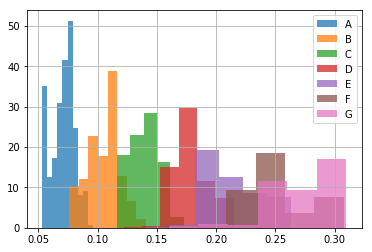

In [3]:
# Plot distribution of interest rates for each loan grade

for grade in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    subset = frame['grade'] == grade
    frame['int_rate_num'][subset].hist(label = grade, normed = True, alpha = 0.75)

plt.legend()
plt.show()

# Plot distribution of interest rates for each loan subgrade

# for sub_grade in {sg for sg in set(frame['sub_grade']) if sg == sg}:
#     subset = frame['sub_grade'] == sub_grade
#     frame['int_rate_num'][subset].hist(label = sub_grade, normed = True, alpha = 0.75)

# plt.legend()
# plt.show()

## Add dummies, remove NAs, split into training and test

In [4]:
# Construct data frame of just pre-application characteristics

frame_completed = frame[frame.loan_status != 'Current']

post_variables = ["all_util", "term",
                "collection_recovery_fee", 
                "funded_amnt", "funded_amnt_inv", "id", "initial_list_status",
                "installment", "int_rate", "issue_d", "last_credit_pull_d", 
                "last_fico_range_high", "last_fico_range_low", "last_pymnt_amnt",
                "last_pymnt_d", "member_id", "next_pymnt_d", "out_prncp", 
                "out_prncp_inv", "pymnt_plan", "sub_grade", 
                "total_pymnt", "total_pymnt_inv", "total_rec_int", "total_rec_late_fee",
                "total_rec_prncp", "hardship_flag", "hardship_type", "hardship_reason",
                "hardship_status", "deferral_term", "hardship_amount",
                "hardship_start_date", "hardship_end_date", "payment_plan_start_date",
                "hardship_length", "hardship_dpd", "hardship_resaon", "hardship_loan_status",
                "earliest_cr_line", "id", "loan_status", "debt_settlement_flag", 
                "zip_code", "title", "desc", "url", "emp_length", "settlement_status",
                "emp_title", 'settlement_date', "debt_settlement_flag_date", 
                "sec_app_earliest_cr_line", "collection_recovery_fee", "revol_util",
                "late_16_30", "late_31_120", "default", "int_to_total", "late_fees_to_total"]
post_variables = list(set(post_variables).intersection(frame.columns))

pre_data = frame_completed.drop(post_variables, axis=1)
pre_data_dummies = pd.get_dummies(pre_data)

# Drop nas
pre_data_dummies_no_na = pre_data_dummies[pre_data_dummies.columns[pre_data_dummies.isnull().sum() < 100]].dropna()

In [5]:
# Split data into traning and test

from sklearn.model_selection import train_test_split

regressands = ['bad', 'return', 'return2', 'recoveries', 
               "grade_A", "grade_B", "grade_C", "grade_D", "grade_E", "grade_F", "grade_G"]
features = pre_data_dummies_no_na.drop(regressands, axis=1)
labels = pre_data_dummies_no_na[regressands]
_train_features, _test_features, _train_labels, _test_labels = train_test_split(features, labels, test_size = 0.8, 
                                                                            random_state = 42)
train_features, test_features, train_labels, test_labels = _train_features.copy(), _test_features.copy(), _train_labels.copy(), _test_labels.copy()

## Logistic Regression

In [6]:
# Logistic regression of probability of going bad on pre-application characteristics

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_features, train_labels["bad"])
test_features['pred_fail_rate'] = lr.predict_proba(test_features)[:, 1]

## Linear regression

In [7]:
from sklearn import linear_model

linreg = linear_model.LinearRegression()
linreg.fit(train_features, train_labels["bad"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
import statsmodels.api as sm
linregCO = sm.OLS(train_labels["bad"], sm.add_constant(train_features)).fit()
linregCO.summary()

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1042: RuntimeWarning: invalid value encountered in absolute
  return stats.t.sf(np.abs(self.tvalues), df_resid)*2
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructur

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bad   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     179.5
Date:                Mon, 07 May 2018   Prob (F-statistic):               0.00
Time:                        18:57:32   Log-Likelihood:                -87468.
No. Observations:              191667   AIC:                         1.751e+05
Df Residuals:                  191569   BIC:                         1.761e+05
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
loan_amnt                                  1.233e-07   1.27e-07      0.970      0.332   -1.26e-07    3.72e-07
annual_inc                                -1.287e-07   1.28e-08    -10.076      0.000   -1.54e-07   -1.04e-07
delinq_2yrs                                   0.0064      0.001      6.168      0.000       0.004       0.008
inq_last_6mths                                0.0089      0.001      9.576      0.000       0.007       0.011
open_acc                                      0.0040      0.000     17.535      0.000       0.004       0.004
pub_rec                                       0.0032      0.002      2.063      0.039       0.000       0.006
revol_bal                                 -7.816e-08   4.44e-08     -1.762      0.078   -1.65e-07     8.8e-09
total_acc                                    -0.0013      0.000    -12.726      0.000      -0.002      -0.001
policy_code                                  -0.0514      0.011     -4.864      0.000      -0.072      -0.031
acc_now_delinq                                0.0022      0.012      0.189      0.850      -0.021       0.025
delinq_amnt                                1.123e-06    1.2e-06      0.932      0.351   -1.24e-06    3.48e-06
int_rate_num                                  1.5932      0.023     69.243      0.000       1.548       1.638
emp_length_num                               -0.0012      0.000     -3.883      0.000      -0.002      -0.001
term_years                                    0.0372      0.001     30.308      0.000       0.035       0.040
home_ownership_ANY                            0.0916      0.065      1.399      0.162      -0.037       0.220
home_ownership_MORTGAGE                      -0.0354      0.024     -1.486      0.137      -0.082       0.011
home_ownership_NONE                          -0.1168      0.095     -1.236      0.217      -0.302       0.068
home_ownership_OTHER                          0.0039      0.066      0.059      0.953      -0.125       0.133
home_ownership_OWN                           -0.0078      0.024     -0.328      0.743      -0.055       0.039
home_ownership_RENT                           0.0132      0.024      0.552      0.581      -0.034       0.060
verification_status_Not Verified             -0.0323      0.004     -8.638      0.000      -0.040      -0.025
verification_status_Source Verified          -0.0140      0.004     -3.724      0.000      -0.021      -0.007
verification_status_Verified                 -0.0051      0.004     -1.362      0.173      -0.013       0.002
purpose_car                                  -0.0190      0.009     -2.162      0.031      -0.036      -0.002
purpose_credit_card                          -0.0033      0.005     -0.705      0.481      -0.013       0.006
pur

## Explore returns

In [9]:
linreg_ret = sm.OLS(train_labels["return"], sm.add_constant(train_features)).fit()
linreg_ret.summary()

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1042: RuntimeWarning: invalid value encountered in absolute
  return stats.t.sf(np.abs(self.tvalues), df_resid)*2
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     275.1
Date:                Mon, 07 May 2018   Prob (F-statistic):               0.00
Time:                        18:57:41   Log-Likelihood:             2.0260e+05
No. Observations:              191667   AIC:                        -4.050e+05
Df Residuals:                  191569   BIC:                        -4.040e+05
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
loan_amnt                                 -1.803e-07    2.8e-08     -6.444      0.000   -2.35e-07   -1.25e-07
annual_inc                                 2.249e-08   2.81e-09      7.999      0.000     1.7e-08     2.8e-08
delinq_2yrs                                  -0.0009      0.000     -4.162      0.000      -0.001      -0.001
inq_last_6mths                               -0.0026      0.000    -12.561      0.000      -0.003      -0.002
open_acc                                     -0.0007   5.08e-05    -12.962      0.000      -0.001      -0.001
pub_rec                                       0.0003      0.000      0.848      0.396      -0.000       0.001
revol_bal                                  3.248e-08   9.77e-09      3.326      0.001    1.33e-08    5.16e-08
total_acc                                     0.0002   2.33e-05      8.816      0.000       0.000       0.000
policy_code                                   0.3733      0.002    160.329      0.000       0.369       0.378
acc_now_delinq                                0.0003      0.003      0.099      0.921      -0.005       0.005
delinq_amnt                               -4.103e-07   2.65e-07     -1.548      0.122    -9.3e-07    1.09e-07
int_rate_num                                 -0.1083      0.005    -21.374      0.000      -0.118      -0.098
emp_length_num                                0.0002   6.89e-05      2.821      0.005    5.94e-05       0.000
term_years                                   -0.0049      0.000    -17.980      0.000      -0.005      -0.004
home_ownership_ANY                            0.0450      0.014      3.123      0.002       0.017       0.073
home_ownership_MORTGAGE                       0.0636      0.005     12.121      0.000       0.053       0.074
home_ownership_NONE                           0.0956      0.021      4.593      0.000       0.055       0.136
home_ownership_OTHER                          0.0585      0.014      4.047      0.000       0.030       0.087
home_ownership_OWN                            0.0575      0.005     10.927      0.000       0.047       0.068
home_ownership_RENT                           0.0530      0.005     10.107      0.000       0.043       0.063
verification_status_Not Verified              0.1274      0.001    154.647      0.000       0.126       0.129
verification_status_Source Verified           0.1240      0.001    150.125      0.000       0.122       0.126
verification_status_Verified                  0.1219      0.001    146.697      0.000       0.120       0.123
purpose_car                                   0.0322      0.002     16.594      0.000       0.028       0.036
purpose_credit_card                           0.0295      0.001     28.254      0.000       0.027       0.032
pur

In [10]:
linreg_rec = sm.OLS(train_labels[train_labels.bad == 0]["return"], 
                    sm.add_constant(train_features[train_labels.bad == 0])).fit()
linreg_rec.summary()

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1042: RuntimeWarning: invalid value encountered in absolute
  return stats.t.sf(np.abs(self.tvalues), df_resid)*2
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     703.3
Date:                Mon, 07 May 2018   Prob (F-statistic):               0.00
Time:                        18:57:46   Log-Likelihood:             2.7316e+05
No. Observations:              153619   AIC:                        -5.461e+05
Df Residuals:                  153521   BIC:                        -5.451e+05
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
loan_amnt                                 -1.209e-07   1.53e-08     -7.903      0.000   -1.51e-07   -9.09e-08
annual_inc                                -2.659e-09   1.67e-09     -1.594      0.111   -5.93e-09     6.1e-10
delinq_2yrs                               -5.648e-05      0.000     -0.446      0.656      -0.000       0.000
inq_last_6mths                               -0.0005      0.000     -4.378      0.000      -0.001      -0.000
open_acc                                   -4.28e-05   2.79e-05     -1.536      0.125   -9.74e-05    1.18e-05
pub_rec                                    8.459e-05      0.000      0.455      0.649      -0.000       0.000
revol_bal                                  2.558e-08   5.28e-09      4.842      0.000    1.52e-08    3.59e-08
total_acc                                 -2.349e-05   1.27e-05     -1.850      0.064   -4.84e-05    1.39e-06
policy_code                                   0.3747      0.001    296.034      0.000       0.372       0.377
acc_now_delinq                                0.0009      0.001      0.643      0.520      -0.002       0.004
delinq_amnt                               -5.433e-09   1.56e-07     -0.035      0.972   -3.11e-07       3e-07
int_rate_num                                  0.2205      0.003     78.410      0.000       0.215       0.226
emp_length_num                             4.403e-06   3.74e-05      0.118      0.906    -6.9e-05    7.78e-05
term_years                                   -0.0065      0.000    -42.417      0.000      -0.007      -0.006
home_ownership_ANY                            0.0741      0.008      9.380      0.000       0.059       0.090
home_ownership_MORTGAGE                       0.0569      0.003     20.609      0.000       0.051       0.062
home_ownership_NONE                           0.0788      0.011      7.442      0.000       0.058       0.100
home_ownership_OTHER                          0.0541      0.008      6.958      0.000       0.039       0.069
home_ownership_OWN                            0.0558      0.003     20.126      0.000       0.050       0.061
home_ownership_RENT                           0.0550      0.003     19.912      0.000       0.050       0.060
verification_status_Not Verified              0.1250      0.000    279.701      0.000       0.124       0.126
verification_status_Source Verified           0.1249      0.000    278.055      0.000       0.124       0.126
verification_status_Verified                  0.1248      0.000    275.999      0.000       0.124       0.126
purpose_car                                   0.0281      0.001     27.245      0.000       0.026       0.030
purpose_credit_card                           0.0279      0.001     49.047      0.000       0.027       0.029
pur

In [11]:
linreg_rec_rate = sm.OLS(train_labels[train_labels.bad == 1]["return"], 
                         sm.add_constant(train_features[train_labels.bad == 1])).fit()
linreg_rec_rate.summary()
test_features["pred_rec_rate"] = linreg_rec_rate.predict(test_features.drop("pred_fail_rate", 1))

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1042: RuntimeWarning: invalid value encountered in absolute
  return stats.t.sf(np.abs(self.tvalues), df_resid)*2
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [12]:
np.corrcoef(test_features[["pred_fail_rate", "pred_rec_rate"]], rowvar=0)

array([[ 1.       ,  0.0147042],
       [ 0.0147042,  1.       ]])

In [13]:
# Compute expected gross return R

test_features["exp_R"] = ((1 + test_features["int_rate_num"]) * (1 - test_features["pred_fail_rate"]) +
                         test_features["pred_rec_rate"] * test_features["pred_fail_rate"])

## Are cross moments predictable?

In [14]:
features1 = train_features.iloc[:1000, :20].copy()
labels1 = train_labels.iloc[:1000, :20].copy()
features2 = train_features.iloc[1000:2000, :20].copy()
labels2 = train_labels.iloc[1000:2000, :20].copy()

## Predicting variances

In [15]:
linreg_rec_rate2 = sm.OLS(train_labels[train_labels.bad == 1]["return"] ** 2, 
                         sm.add_constant(train_features[train_labels.bad == 1])).fit()
linreg_rec_rate2.summary()
test_features["pred_rec_rate2"] = linreg_rec_rate2.predict(sm.add_constant(test_features.iloc[:,:107]))

test_features["var_R"] = ((1 + test_features["int_rate_num"])**2 * (1 - test_features["pred_fail_rate"]) +
                         test_features["pred_rec_rate2"] * test_features["pred_fail_rate"] 
                         - test_features["exp_R"]**2)

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1042: RuntimeWarning: invalid value encountered in absolute
  return stats.t.sf(np.abs(self.tvalues), df_resid)*2
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## Fitting preferences

In [16]:
risk_factors = test_features[["exp_R", "var_R"]].copy()
risk_factors["const"] = 1
grades = test_labels[["grade_A", "grade_B", "grade_C", "grade_D", "grade_E", "grade_F", "grade_G"]]

In [17]:
# def sigmoid(z):
#     return 1 / (1 + np.exp(-z))

# initial_parameters = np.ndarray([3,7]) + np.random.rand(3,7)

# guess = sigmoid(np.matmul(risk_factors, initial_parameters))

# def cost(parameters):
#     parameters = np.reshape(parameters, (3, 7))
#     guess = np.matmul(risk_factors.iloc[:20000,:].values, parameters)
#     guess = guess / np.sum(guess, 1, keepdims=True)
#     return np.log(np.sum((guess - grades.iloc[:20000, :].values)**2))

# cost(initial_parameters)

In [18]:
# import scipy.optimize

# result = scipy.optimize.minimize(cost, initial_parameters, method="Powell")
# result

In [19]:
# np.reshape(result.x, (3,7))[1,:] / np.reshape(result.x, (3,7))[0,:]

In [20]:
# np.reshape(result.x, (3,7))[1,:]

In [21]:
# parameters = np.reshape(result.x, (3, 7))
# guess = sigmoid(np.matmul(risk_factors.iloc[:10000,:].values, parameters))
# guess = guess / np.sum(guess, 1, keepdims=True)
# assignments = guess.argmax(1)

In [22]:
# assignments[100:200]

## Regrssions of loan grades on returns and variance

In [23]:
test_features["loan_weight"] = test_features["loan_amnt"] / np.sum(test_features["loan_amnt"])
test_features.eval("w_exp_R = exp_R * loan_weight", inplace=True)
test_features.eval("w_var_R = var_R * (loan_weight ** 2)", inplace=True)

In [24]:
sm.OLS(grades["grade_A"], sm.add_constant(test_features[["var_R", "exp_R"]])).fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                grade_A   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                 8.682e+04
Date:                Mon, 07 May 2018   Prob (F-statistic):               0.00
Time:                        18:58:11   Log-Likelihood:            -1.8489e+05
No. Observations:              766669   AIC:                         3.698e+05
Df Residuals:                  766666   BIC:                         3.698e+05
Df Model:                           2                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3971      0.011    417.344      0.000       4.376       4.418
var_R        -14.8157      0.054   -274.588      0.000     -14.921     -14.710
exp_R         -3.7449      0.009   -401.762      0.000      -3.763      -3.727
==============================================================================
Omnibus:                    93386.372   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           128470.674
Skew:                           0.992   Prob(JB):                         0.00
Kurtosis:                       2.707   Cond. No.                         182.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [25]:
logit = sm.Logit(grades[["grade_A"]], sm.add_constant(test_features[["var_R", "exp_R"]]))
logit.fit().summary()

/anaconda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 12


AttributeError: module 'scipy.stats' has no attribute 'chisqprob'

## Skewness

In [26]:
linreg_rec_rate3 = sm.OLS(train_labels[train_labels.bad == 1]["return"] ** 3, 
                         sm.add_constant(train_features[train_labels.bad == 1])).fit()
linreg_rec_rate3.summary()

test_features["pred_rec_rate3"] = linreg_rec_rate3.predict(test_features.iloc[:, :107])

test_features["exp_R3"] = ((1 + test_features["int_rate_num"])**3 * (1 - test_features["pred_fail_rate"]) +
                           test_features["pred_rec_rate3"] * test_features["pred_fail_rate"])

test_features.eval("skew_R = (exp_R3 - 3 * exp_R * var_R - exp_R ** 3)", inplace=True)

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1042: RuntimeWarning: invalid value encountered in absolute
  return stats.t.sf(np.abs(self.tvalues), df_resid)*2
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [27]:
sm.OLS(grades["grade_A"], sm.add_constant(test_features[["var_R", "skew_R"]])).fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                grade_A   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                 4.292e+04
Date:                Mon, 07 May 2018   Prob (F-statistic):               0.00
Time:                        18:58:35   Log-Likelihood:            -2.7852e+05
No. Observations:              766669   AIC:                         5.570e+05
Df Residuals:                  766666   BIC:                         5.571e+05
Df Model:                           2                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3892      0.001    371.421      0.000       0.387       0.391
var_R        -10.9838      0.070   -156.827      0.000     -11.121     -10.846
skew_R        21.1914      0.325     65.142      0.000      20.554      21.829
==============================================================================
Omnibus:                   169244.151   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           305622.230
Skew:                           1.504   Prob(JB):                         0.00
Kurtosis:                       3.722   Cond. No.                     1.11e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
import statsmodels.stats.outliers_influence

statsmodels.stats.outliers_influence.variance_inflation_factor(test_features[["var_R", "skew_R"]].values, 1)

13.106310016762196

## Plot distribution of expected returns

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


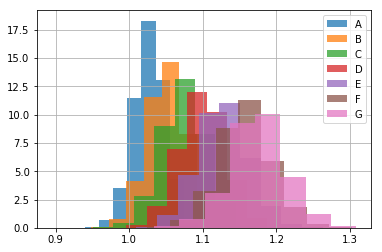

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is tryi

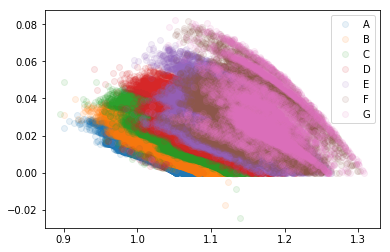

In [29]:
# Plot distribution of interest rates for each loan grade

for grade in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    subset = test_labels['grade_' + grade] == 1
    test_features['exp_R'][subset].hist(label = grade, normed = True, alpha = 0.75)

plt.legend()
plt.show()

# Plot loans in mean-variance space

test_features["grade"] = ""
test_features["grade"][test_labels.grade_A == 1] = "A"
test_features["grade"][test_labels.grade_B == 1] = "B"
test_features["grade"][test_labels.grade_C == 1] = "C"
test_features["grade"][test_labels.grade_D == 1] = "D"
test_features["grade"][test_labels.grade_E == 1] = "E"
test_features["grade"][test_labels.grade_F == 1] = "F"
test_features["grade"][test_labels.grade_G == 1] = "G"

for name, group in test_features.groupby("grade"):
    plt.plot(group.exp_R, group.var_R, marker='o', linestyle='', label=name, alpha = 0.1)

plt.legend()
plt.show()

## Separate Regressions for Each Loan Grade

In [30]:
# Regressions of rates on personal characteristics

train_features_no_int = train_features.iloc[:, :107].drop("int_rate_num", 1)
test_features_no_int = test_features.iloc[:, :107].drop("int_rate_num", 1)

for grade in ["A", "B", "C", "D", "E", "F", "G"]: 
    
    lr_fail_rate = LogisticRegression()
    lr_fail_rate.fit(train_features_no_int[train_labels["grade_" + grade] == 1], 
                     train_labels[train_labels["grade_" + grade] == 1]["bad"])
    test_features["pred_fail_rate_" + grade] = lr_fail_rate.predict_proba(test_features_no_int)[:, 1]
    
    mask = (train_labels["grade_" + grade] == 1) & (train_labels["bad"] == 1)
    lr_rec_rate = sm.OLS(train_labels[mask]["return"], sm.add_constant(train_features_no_int[mask])).fit()
    test_features["pred_rec_rate_" + grade] = lr_rec_rate.predict(test_features_no_int)
    
    lr_rec_rate2 = sm.OLS(train_labels[mask]["return"] ** 2, sm.add_constant(train_features_no_int[mask])).fit()
    test_features["pred_rec_rate2_" + grade] = lr_rec_rate2.predict(test_features_no_int)
    
    r = np.mean(train_features[train_labels["grade_" + grade] == 1]["int_rate_num"])
    
    test_features["exp_R_" + grade] = ((1 + r) * (1 - test_features["pred_fail_rate_" + grade]) +
                         test_features["pred_rec_rate_" + grade] * test_features["pred_fail_rate_" + grade])
    
    test_features["var_R_" + grade] = ((1 + r)**2 * (1 - test_features["pred_fail_rate_" + grade]) +
                         test_features["pred_rec_rate2_" + grade] * test_features["pred_fail_rate_" + grade] 
                         - test_features["exp_R_" + grade]**2)

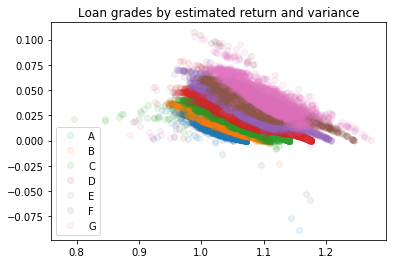

In [31]:
for name, group in test_features.groupby("grade"):
    plt.plot(group["exp_R_" + name], group["var_R_" + name], marker='o', linestyle='', label=name, alpha = 0.1)

plt.legend()
plt.title("Loan grades by estimated return and variance")
plt.show()

## ML Discrete Choice Model

In [118]:
# Define negative log-likelihood function

def nllh(beta, features, labels):
    utilities = {}
    for grade in ["A", "B", "C", "D", "E", "F", "G"]:
        utilities[grade] = np.dot(features[["const", "exp_R_" + grade, "var_R_" + grade]].values, beta)
    utilitiesArray = pd.DataFrame(utilities).values
    indicatorArray = labels[["grade_" + x for x in ["A", "B", "C", "D", "E", "F", "G"]]].values
    term1 = np.sum(utilitiesArray * indicatorArray, axis=1)
    term2 = np.log(np.sum(np.exp(utilitiesArray), axis=1))
    return -1 * np.sum(term1 - term2)

In [120]:
nllh([1,1,1], test_features, test_labels)

1502939.3044675051

In [122]:
# Run maximum likelihood estimation

import scipy.optimize

scipy.optimize.minimize(nllh, [0,0,0], args=(test_features, test_labels), method='Nelder-Mead')

 final_simplex: (array([[ 15.54805346,   6.429981  , -53.82657096],
       [ 15.54803769,   6.42999714, -53.82651434],
       [ 15.54806696,   6.43007699, -53.82660962],
       [ 15.54804304,   6.43005984, -53.82652716]]), array([ 1322473.47754485,  1322473.47754486,  1322473.4775449 ,
        1322473.47754512]))
           fun: 1322473.4775448511
       message: 'Optimization terminated successfully.'
          nfev: 295
           nit: 154
        status: 0
       success: True
             x: array([ 15.54805346,   6.429981  , -53.82657096])